# ML Project (group 9)


# Table of contents

1. [$\color{orange}{\text{Question 1}}$](#Q1)
    2. [Data preprocessing](#cleaning)
    3. [Quick model check](#check)
    4. [Feature selection](#feature)
2. [$\color{orange}{\text{Question 2}}$](#Q2)
    1. [General Introduction](#subparagraph1)
    2. [K-CV Loop](#subparagraph2)
    3. [$\color{purple}{\text{Random Forests}}$](#subparagraph3)
        1. [Intro](#rf-intro)
        2. [HP Search with K-CV](#rf-hp-kcv)
        3. [HP Search with OOB](#rf-hp-oob)
        4. [Variable Importance with RF](#rf-importance)
        5. [Final choice; testing results](#testrf)
    4. [$\color{purple}{\text{Lazy NN}}$](#subparagraph4)
    5. [$\color{purple}{\text{Lasso}}$](#subparagraph5)
3. [$\color{orange}{\text{Question 3}}$](#Q3)
    1. [$\color{purple}{\text{Gradient boosted trees}}$](#q3-intro)
    2. [HP Search with caret()](#caret)
    3. [Overview of the results of all models](#over)
    4. [Choice of best model](#choice)
4. [$\color{orange}{\text{Question 4}}$](#Q4)
5. [$\color{orange}{\text{Question 5}}$](#Q5)
    1. [Introduction](#q5-intro)
    2. [Pseudo Code](#q5-code)
    3. [Application to boosted trees](#appli)
    4. [Discussion of Variable Importance](#q5-discussion)
   

















# Question 1 <a name="Q1"></a>


In [1]:
#install.packages('tidyverse')
#install.packages('tidymodels')
#install.packages("GGally")
#install.packages("kernlab")

#install.packages("tree")
#install.packages("rpart")
#install.packages("e1071")
#install.packages("lazy")



In [64]:
library("tidyverse")
library("tidymodels")
library("GGally")
library("kernlab")


In [67]:
set.seed(12345)
getwd()

[1] "C:/Users/User/Downloads"

## A first look at our data

In [68]:
raw_train_data <- read.csv("Train.csv", header = T, na.strings = "NA") #we read our train data from .csv file
#summary(raw_train_data)  #can be useful to check how the data looks
dim(raw_train_data) #- dim(na.omit(raw_train_data))

raw_test_data <- read.csv("Test.csv", header = T, na.strings = "NA") #we read our test data from .csv file
#summary(raw_test_data)  #can be useful to check how the data looks
dim(raw_test_data) #- dim(na.omit(raw_test_data))

[1] 30557    82

[1] 16136    77

We can see that we have many missing values, we have categorical features and numeric ones and we have 4 columns where the data is directly related to our target feature.

## Data preprocessing (cleaning) <a name="cleaning"></a>

We have some categorical features in our data, such as : Place_ID.X.Date , Date, Place_ID. 
And we decide to remove them since they impact the reads the target through the other features 

We also want to remove the features who are directly correlated to the target feature for a specific date and time (plus these features can only be computed after prediction of the target feature).

The same holds for the data used for testing

In [69]:
unecessary <- c("Place_ID.X.Date","Date","Place_ID","target_min","target_max","target_variance","target_count")
train_data <- raw_train_data[, ! colnames(raw_train_data) %in% unecessary] #We remove the unecessary features
dim(train_data)

unecessary_test <- c("Place_ID.X.Date","Date","Place_ID")
test_data <- raw_test_data[, ! colnames(raw_test_data) %in% unecessary] #We remove the unecessary features
dim(test_data)

dim(raw_train_data["target"])-dim(na.omit(raw_train_data["target"])) 
#Also, the target feature doesn't have missing values

[1] 30557    75

[1] 16136    74

[1] 0 0

But our datasets still contain a lot of data that we still need to process for example the missing values. Let's see how many missing values we have in our train_data. 

In [70]:
lapply(train_data, function(x) sum(is.na(x))) %>% str() 
#how much missing values per feature do we have (in contrast with how many rows are affected by missing values):
A <- matrix(dim(train_data)- dim(na.omit(train_data)))
C <- matrix(dim(train_data))
print(paste("There are",A[1],"in", C[1],"rows affected by missing values in train_data"))


#we can do the same for test_data
#lapply(test_data, function(x) sum(is.na(x))) %>% str() 
#B <- matrix(dim(test_data)- dim(na.omit(test_data)))
#D <- matrix(dim(test_data))
#print(paste("There are",B[1],"in",D[1],"rows affected by missing values in test_data"))

List of 75
 $ target                                             : int 0
 $ precipitable_water_entire_atmosphere               : int 0
 $ relative_humidity_2m_above_ground                  : int 0
 $ specific_humidity_2m_above_ground                  : int 0
 $ temperature_2m_above_ground                        : int 0
 $ u_component_of_wind_10m_above_ground               : int 0
 $ v_component_of_wind_10m_above_ground               : int 0
 $ L3_NO2_NO2_column_number_density                   : int 2189
 $ L3_NO2_NO2_slant_column_number_density             : int 2189
 $ L3_NO2_absorbing_aerosol_index                     : int 2189
 $ L3_NO2_cloud_fraction                              : int 2189
 $ L3_NO2_sensor_altitude                             : int 2189
 $ L3_NO2_sensor_azimuth_angle                        : int 2190
 $ L3_NO2_sensor_zenith_angle                         : int 2190
 $ L3_NO2_solar_azimuth_angle                         : int 2190
 $ L3_NO2_solar_zenith_angle       

We see that more than 85% of our data concerning CH4 done by the Sentinel 5P satellite are missing values. We might as well not look at these features.

We create a dataframe where we've dropped them :

In [71]:
CH4 <- c("L3_CH4_CH4_column_volume_mixing_ratio_dry_air","L3_CH4_aerosol_height","L3_CH4_aerosol_optical_depth","L3_CH4_sensor_azimuth_angle","L3_CH4_sensor_zenith_angle","L3_CH4_solar_azimuth_angle","L3_CH4_solar_zenith_angle")
train_data <- train_data[, ! colnames(train_data) %in% CH4]
dim(train_data)

[1] 30557    68

We also see a very strong correlation between the gases for their sensor_zenith_angle (>0.82), sensor_azimuth_angle (>0.92), solar_azimuth_angle (>0.75) and solar_zenith_angle (>0.80) features (we only look at results that have no missing values in every features, so we have a smaller sample, but it's a "raw" sample). This makes sense because in practice, we measure different gases with the same equipement and calibration (otherwise it would be hard to compare the results). Also we don't check for the aerosols (AER) because as we see later we will just discard all the data concerning aerosols.

So we decide to keep one of each "angle"-features corresponding to the gases most correlated with the target :

In [72]:
no_na_data <- na.omit(train_data) # We work with a reduced set but with the true correlation between the features
no_na_target <- na.omit(train_data)$target

no_na_data_sensor_zenith_angle <- no_na_data %>% select("L3_CO_sensor_zenith_angle", "L3_NO2_sensor_zenith_angle", "L3_O3_sensor_zenith_angle", "L3_CLOUD_sensor_zenith_angle", "L3_SO2_sensor_zenith_angle", "L3_HCHO_sensor_zenith_angle")
#cor(no_na_data_sensor_zenith_angle)
corr_w_taregt_sensor_zenith <- abs(cor(no_na_data_sensor_zenith_angle,no_na_target))
ranking_corr_t_se_ze <- sort(corr_w_taregt_sensor_zenith,decreasing=TRUE,index.return=T)$ix

no_na_data_sensor_azimuth_angle <- no_na_data %>% select("L3_CO_sensor_azimuth_angle", "L3_NO2_sensor_azimuth_angle", "L3_O3_sensor_azimuth_angle", "L3_CLOUD_sensor_azimuth_angle", "L3_SO2_sensor_azimuth_angle", "L3_HCHO_sensor_azimuth_angle")
#cor(no_na_data_sensor_azimuth_angle)
corr_w_taregt_sensor_azimuth <- abs(cor(no_na_data_sensor_azimuth_angle,no_na_target))
ranking_corr_t_se_az <- sort(corr_w_taregt_sensor_azimuth,decreasing=TRUE,index.return=T)$ix

no_na_data_solar_azimuth_angle <- no_na_data %>% select("L3_CO_solar_azimuth_angle", "L3_NO2_solar_azimuth_angle", "L3_O3_solar_azimuth_angle", "L3_CLOUD_solar_azimuth_angle", "L3_SO2_solar_azimuth_angle", "L3_HCHO_solar_azimuth_angle")
#cor(no_na_data_solar_azimuth_angle)
corr_w_taregt_solar_azimuth <- abs(cor(no_na_data_solar_azimuth_angle,no_na_target))
ranking_corr_t_so_az <- sort(corr_w_taregt_solar_azimuth,decreasing=TRUE,index.return=T)$ix

no_na_data_solar_zenith_angle <- no_na_data %>% select("L3_CO_solar_zenith_angle", "L3_NO2_solar_zenith_angle", "L3_O3_solar_zenith_angle", "L3_CLOUD_solar_zenith_angle", "L3_SO2_solar_zenith_angle", "L3_HCHO_solar_zenith_angle")
#cor(no_na_data_solar_zenith_angle)
corr_w_taregt_solar_zenith <- abs(cor(no_na_data_solar_zenith_angle,no_na_target))
ranking_corr_t_so_ze <- sort(corr_w_taregt_solar_zenith,decreasing=TRUE,index.return=T)$ix

#We create a list with the names of all the angle features that we don't want to keep :
rk_sen_zen <- names(no_na_data_sensor_zenith_angle[ranking_corr_t_se_ze[1:6]])
rk_sen_azi <- names(no_na_data_sensor_azimuth_angle[ranking_corr_t_se_az[1:6]])
rk_sol_azi <- names(no_na_data_solar_azimuth_angle[ranking_corr_t_so_az[1:6]])
rk_sol_zen <- names(no_na_data_solar_zenith_angle[ranking_corr_t_so_ze[1:6]])

rejected_angle_features <- cbind(rk_sen_zen[2:6],rk_sen_azi[2:6],rk_sol_azi[2:6],rk_sol_zen[2:6])

train_data <- train_data[, ! colnames(train_data) %in% rejected_angle_features]

dim(train_data)



[1] 30557    48

And as we can see below there is no strong correlation between the "angle"-features that we've decided to keep.

In [73]:
no_na_train_data <- na.omit(train_data)
angle_features <- cbind(no_na_train_data[rk_sen_zen[1]], no_na_train_data[rk_sen_azi[1]], no_na_train_data[rk_sol_azi[1]],no_na_train_data[rk_sol_zen[1]])

cor(angle_features)

,L3_NO2_sensor_zenith_angle,L3_CO_sensor_azimuth_angle,L3_CLOUD_solar_azimuth_angle,L3_CLOUD_solar_zenith_angle
L3_NO2_sensor_zenith_angle,1.00000000,-0.01490178,0.2358748,0.1021618
L3_CO_sensor_azimuth_angle,-0.01490178,1.00000000,-0.1543911,-0.1055222
L3_CLOUD_solar_azimuth_angle,0.23587483,-0.15439109,1.0000000,0.1183659
L3_CLOUD_solar_zenith_angle,0.10216185,-0.10552218,0.1183659,1.0000000


Next we need to find a way to replace the missing values such that our variance doesn't increase a lot. We choose to replace them by the mean or by the median depending on which has a lower variance :

In [74]:
# a function that replaces missing values with the mean in a selected feature
replace_with_mean <- function(x){
    mean_value <- mean(x,na.rm=TRUE)  #we strip the missing values
    x[is.na(x)] <- mean_value  
    return(x)
}
# a function that replaces missing values with the mean in a selected feature
replace_with_median <- function(x){
    median_value <- median(x,na.rm=TRUE)  #we strip the missing values
    x[is.na(x)] <- median_value  
    return(x)
}



for(i in colnames(train_data[2:ncol(train_data)])){    #target feature in position 1 has no missing values
    imputed_with_mean <- replace_with_mean(train_data[,i])
    imputed_with_median <- replace_with_median(train_data[,i])
    if (sd(imputed_with_mean) <= sd(imputed_with_median)){ #we check which method is the best
        train_data[,i] <- imputed_with_mean       #and we also apply it to the test_data so that we keep having coherence in the data
        test_data[,i] <- replace_with_mean(test_data[,i])
    } else {
        train_data[,i] <- imputed_with_median
        test_data[,i] <- replace_with_median(test_data[,i])
    }
}


#we can verify that it worked :
dim(train_data)-dim(na.omit(train_data))


[1] 0 0

We also want to check if there are features who do not have missing values but instead have a lot of identical values (hence tempering our data). If a feature has a lot of similare values, let's say 99% of them, then we lose almost nothing by removing them (we remove quasi constant features) : 

(The features concerning the aerosol reads have quasi constant values)

In [75]:
threshold <-0.99   #we want to remove columns who's values are repeated 99% of the time
dropped_train_data <- train_data
dropped <- c()
for (feature in colnames(train_data)){
    prop_unique <- dim(unique(train_data[feature]))[1]/dim(train_data[feature])[1]    #we calculate the ratio between the number of different values and the total number of values for each feature.
    if (prop_unique > threshold){      #when the ratio exceeds a predefinned threshold we remove the unecessary features from the dataset.
        dropped <- append(dropped, feature)  
        print(paste("This feature has 99% of values which are similare :",feature))
        dropped_train_data <- dropped_train_data %>% select(-feature)
    }
}
train_data <- dropped_train_data
#dropped
dim(train_data)

proportion <- dim(unique(train_data["target"]))[1]/dim(train_data["target"])[1]

print(paste("For the target feature :", round(proportion*100,digits=4), "% of the data are similar"))

[1] "This feature has 99% of values which are similare : L3_AER_AI_absorbing_aerosol_index"
[1] "This feature has 99% of values which are similare : L3_AER_AI_sensor_altitude"
[1] "This feature has 99% of values which are similare : L3_AER_AI_sensor_azimuth_angle"
[1] "This feature has 99% of values which are similare : L3_AER_AI_sensor_zenith_angle"
[1] "This feature has 99% of values which are similare : L3_AER_AI_solar_azimuth_angle"
[1] "This feature has 99% of values which are similare : L3_AER_AI_solar_zenith_angle"


[1] 30557    42

[1] "For the target feature : 1.2272 % of the data are similar"


In [76]:
#summary(train_data)

Now let's separate the train_data set into 2 dataframes, one with the weather feaures and one with the gazes so that we can see better how each of the features are correlated withwith the target feature :

In [77]:

train_data_weather <- train_data[2:7]
train_data_gas <- train_data[8:ncol(train_data)]

correlation_weather <- abs(cor(train_data_weather, train_data$target)) # Compute the correlation between the features and the target 
ranking_weather <- sort(correlation_weather,decreasing=TRUE,index.return=T)$ix # Returns features values sorted from most correlated to least correlated 
values_weather <- sort(correlation_weather,decreasing=TRUE,index.return=T)$x # Returns the features from most to least correlated 
ranked_corr_weather <- cbind(names(train_data_weather[,ranking_weather]),values_weather)
#ranked_corr_weather
correlation_gas <- abs(cor(train_data_gas, train_data$target)) # Compute the correlation between the features and the target 
ranking_gas <- sort(correlation_gas,decreasing=TRUE,index.return=T)$ix # Returns features values sorted from most correlated to least correlated 
values_gas <- sort(correlation_gas,decreasing=TRUE,index.return=T)$x # Returns the features from most to least correlated 
ranked_corr_gas <- cbind(names(train_data_gas[,ranking_gas]),values_gas)
ranked_corr_gas

,values_gas
L3_CO_CO_column_number_density,0.341726915612253
L3_HCHO_tropospheric_HCHO_column_number_density,0.309343418338481
L3_NO2_NO2_slant_column_number_density,0.303844661947
L3_NO2_NO2_column_number_density,0.295235182330978
L3_HCHO_HCHO_slant_column_number_density,0.285926765246318
L3_NO2_tropospheric_NO2_column_number_density,0.252195695335824
L3_CLOUD_solar_azimuth_angle,0.186807688476243
L3_SO2_absorbing_aerosol_index,0.136017120209669
L3_CLOUD_cloud_top_pressure,0.122033415604367
L3_NO2_cloud_fraction,0.119294063295941


Now let's look at individually at the weather features and the features for each gazes and look how they are correleted between them. If they have a strong correlation we might want to drop the ones less correlated with the target feature.

In [78]:
cor_weather <- cor(train_data_weather)
#cor_weather

"precipitable_water_entire_atmosphere" and "specific_humidity_2m_above_ground" have a strong correlation and "specific_humidity_2m_above_ground" and "temperature_2m_above_ground" also have a strong correlation.

So let's drop "specific_humidity_2m_above_ground" and "temperature_2m_above_ground"

In [79]:
CO_gas <- train_data %>% select("L3_CO_CO_column_number_density","L3_CO_H2O_column_number_density","L3_CO_cloud_height","L3_CO_sensor_altitude","L3_CO_sensor_azimuth_angle")
# note that we have removed "L3_CO_solar_azimuth_angle","L3_CO_sensor_zenith_angle" and "L3_CO_solar_zenith_angle".
cor_CO <- cor(CO_gas)
#cor_CO

There's no strong correlation between the features of the CO gaz

In [80]:
NO2_gas <- train_data %>% select("L3_NO2_NO2_slant_column_number_density","L3_NO2_NO2_column_number_density","L3_NO2_tropospheric_NO2_column_number_density","L3_NO2_sensor_zenith_angle","L3_NO2_cloud_fraction","L3_NO2_absorbing_aerosol_index","L3_NO2_sensor_altitude","L3_NO2_tropopause_pressure","L3_NO2_stratospheric_NO2_column_number_density")
# note that we have removed "L3_NO2_sensor_zenith_angle" and "L3_NO2_sensor_azimuth_angle"
cor_NO2 <- cor(NO2_gas)
#cor_NO2

We remark a strong correlation between L3_NO2_NO2_slant_column_number_density, L3_NO2_NO2_column_number_density and L3_NO2_tropospheric_NO2_column_number_density, thoses features are kind of measures of the same thing so we might as well delete 2 of them and keep the one that's more corrolated with the target.



Let's keep L3_NO2_NO2_slant_column_number_density and rejected the 2 others.

In [81]:
CLOUD <- train_data %>% select("L3_CLOUD_cloud_top_pressure","L3_CLOUD_cloud_top_height","L3_CLOUD_cloud_base_pressure","L3_CLOUD_cloud_base_height","L3_CLOUD_cloud_optical_depth","L3_CLOUD_cloud_fraction","L3_CLOUD_surface_albedo")
# note that we have removed "L3_CLOUD_solar_azimuth_angle", "L3_CLOUD_solar_zenith_angle" and "L3_CLOUD_sensor_azimuth_angle"
cor_CLOUD <- cor(CLOUD)
#cor_CLOUD

We have a strong correlation between L3_CLOUD_cloud_top_pressure, L3_CLOUD_cloud_top_height, L3_CLOUD_cloud_base_pressure and L3_CLOUD_cloud_base_height (which makes sense since pressure increases with height)

Let's juste keep L3_CLOUD_cloud_top_pressure.

In [82]:
SO2_gas <- train_data %>% select("L3_SO2_absorbing_aerosol_index","L3_SO2_SO2_slant_column_number_density","L3_SO2_SO2_column_number_density","L3_SO2_cloud_fraction","L3_SO2_SO2_column_number_density_amf")
# note that we have removed "L3_SO2_solar_azimuth_angle","L3_SO2_solar_zenith_angle","L3_SO2_sensor_zenith_angle" and "L3_SO2_sensor_azimuth_angle"
cor_SO2 <- cor(SO2_gas)
#cor_SO2

We have great correlation between L3_SO2_SO2_slant_column_number_density and L3_SO2_SO2_column_number_density (obviously), let's reject L3_SO2_SO2_column_number_density.

In [83]:
O3_gas <- train_data %>% select("L3_O3_O3_column_number_density","L3_O3_cloud_fraction","L3_O3_O3_effective_temperature")
# note that we have removed "L3_O3_solar_azimuth_angle","L3_O3_solar_zenith_angle","L3_O3_sensor_azimuth_angle" and "L3_O3_sensor_zenith_angle"
cor_O3 <- cor(O3_gas)
#cor_O3

No particular correlation concerning the O3 gas 

In [84]:
HCHO_gas <- train_data %>% select("L3_HCHO_HCHO_slant_column_number_density","L3_HCHO_tropospheric_HCHO_column_number_density","L3_HCHO_cloud_fraction","L3_HCHO_tropospheric_HCHO_column_number_density_amf")
# note that we have removed "L3_HCHO_solar_azimuth_angle","L3_HCHO_sensor_zenith_angle","L3_HCHO_solar_zenith_angle" and "L3_HCHO_sensor_azimuth_angle"
cor_HCHO <- cor(HCHO_gas)
#cor_HCHO

Again obviously we have a strong correlation between L3_HCHO_HCHO_slant_column_number_density and L3_HCHO_tropospheric_HCHO_column_number_density, let's reject L3_HCHO_tropospheric_HCHO_column_number_density.

Let's check the 

In [85]:
train_data_rej <- train_data_gas %>% select(-"L3_NO2_NO2_column_number_density", -"L3_NO2_tropospheric_NO2_column_number_density", -"L3_CLOUD_cloud_top_height", -"L3_CLOUD_cloud_base_pressure",-"L3_CLOUD_cloud_base_height",-"L3_SO2_SO2_column_number_density",-"L3_HCHO_tropospheric_HCHO_column_number_density")
correlation_gas_rej <- abs(cor(train_data_rej, train_data$target)) # Compute the correlation between the features and the target 
ranking_gas_rej <- sort(correlation_gas_rej,decreasing=TRUE,index.return=T)$ix # Returns features values sorted from most correlated to least correlated 
values_gas_corr_target <- sort(correlation_gas_rej,decreasing=TRUE,index.return=T)$x # Returns the features from most to least correlated 
ranked_corr_gas_rej <- cbind(names(train_data_rej[,ranking_gas_rej]),values_gas_corr_target)
ranked_corr_gas_rej

,values_gas_corr_target
L3_CO_CO_column_number_density,0.341726915612253
L3_NO2_NO2_slant_column_number_density,0.303844661947
L3_HCHO_HCHO_slant_column_number_density,0.285926765246318
L3_CLOUD_solar_azimuth_angle,0.186807688476243
L3_SO2_absorbing_aerosol_index,0.136017120209669
L3_CLOUD_cloud_top_pressure,0.122033415604367
L3_NO2_cloud_fraction,0.119294063295941
L3_CLOUD_cloud_optical_depth,0.116760596789232
L3_CLOUD_cloud_fraction,0.112717601727827
L3_O3_cloud_fraction,0.108192195954286


For each gases, let's keep at most 3 features that are the most correlated with the target with a correlation of at least 0.4 (that way we don't leave any gases out and we take the most correlated features for each gases). We can see that for each gas we've select some variation of column_number_density :

O3 : "L3_O3_O3_column_number_density", "L3_O3_cloud_fraction"

NO2 : "L3_NO2_NO2_slant_column_number_density", "L3_NO2_solar_azimuth_angle", "L3_NO2_cloud_fraction"

CO : "L3_CO_CO_column_number_density", "L3_CO_cloud_height"

CLOUD : "L3_CLOUD_cloud_top_pressure", "L3_CLOUD_cloud_optical_depth", "L3_CLOUD_cloud_fraction"

HCHO : "L3_HCHO_HCHO_slant_column_number_density"

SO2 : "L3_SO2_absorbing_aerosol_index", "L3_SO2_SO2_slant_column_number_density"

In [86]:
final_train_data_gas_red <- cbind(train_data_gas["L3_O3_O3_column_number_density"], train_data_gas["L3_O3_cloud_fraction"], train_data_gas["L3_NO2_NO2_slant_column_number_density"],  train_data_gas["L3_NO2_cloud_fraction"], train_data_gas["L3_CO_CO_column_number_density"], train_data_gas["L3_CO_cloud_height"], train_data_gas["L3_CLOUD_cloud_top_pressure"], train_data_gas["L3_CLOUD_cloud_optical_depth"], train_data_gas["L3_CLOUD_cloud_fraction"], train_data_gas["L3_HCHO_HCHO_slant_column_number_density"], train_data_gas["L3_SO2_absorbing_aerosol_index"],train_data_gas["L3_SO2_SO2_slant_column_number_density"])
#final_train_data_gas_red
train_data_weather_red <- train_data_weather %>% select(-"specific_humidity_2m_above_ground", -"temperature_2m_above_ground")
#train_data_weather_red
train_data_red <- cbind(train_data_weather_red,final_train_data_gas_red)
train_data_red

precipitable_water_entire_atmosphere,relative_humidity_2m_above_ground,u_component_of_wind_10m_above_ground,v_component_of_wind_10m_above_ground,L3_O3_O3_column_number_density,L3_O3_cloud_fraction,L3_NO2_NO2_slant_column_number_density,L3_NO2_cloud_fraction,L3_CO_CO_column_number_density,L3_CO_cloud_height,L3_CLOUD_cloud_top_pressure,L3_CLOUD_cloud_optical_depth,L3_CLOUD_cloud_fraction,L3_HCHO_HCHO_slant_column_number_density,L3_SO2_absorbing_aerosol_index,L3_SO2_SO2_slant_column_number_density
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
11.000000,60.2,1.996377,-1.22739494,0.1190949,0.000000000,0.0001558203,0.006506796,0.02108025,267.01718,70799.50,18.201564,0.000000000,-1.041264e-05,-1.86147565,-4.046582e-05
14.600000,48.8,3.330430,-1.18810785,0.1151788,0.059432858,0.0001968663,0.018360030,0.02201668,61.21669,99353.67,5.958538,0.059358140,1.144485e-04,-1.45261187,5.021103e-05
16.400000,33.4,5.065727,3.50055909,0.1158759,0.082063007,0.0001704180,0.015903901,0.02067673,134.70034,95671.38,5.755760,0.082246547,2.681088e-05,-1.57295027,5.294885e-05
6.911948,21.3,3.004001,1.09946775,0.1415575,0.121261342,0.0001748593,0.055765467,0.02120710,474.82144,96232.49,6.246885,0.121555499,2.348694e-05,-1.23931676,1.097052e-04
13.900001,44.7,2.621787,2.67055893,0.1263685,0.037919427,0.0001415511,0.028529577,0.03776556,926.92631,52561.52,4.205691,0.037007647,3.724964e-05,0.20248879,1.589104e-04
14.600000,42.2,2.955603,0.96907467,0.1261378,0.063836036,0.0001455166,0.070249175,0.02948608,2288.72367,57752.64,4.608632,0.065998251,9.163087e-06,-0.98781994,8.251524e-06
15.600000,47.1,2.221650,-0.93112057,0.1297614,0.479581983,0.0001786014,0.454566836,0.03685796,1956.05404,71265.96,24.610530,0.491667292,-1.304491e-04,-0.14456523,-1.980799e-04
18.600000,62.4,3.287685,-0.88036132,0.1297687,0.041322732,0.0001988697,0.039568242,0.03509292,634.25025,80324.45,5.347519,0.042774848,7.562204e-07,1.41942853,-8.478791e-05
11.800000,39.0,2.722092,4.18345690,0.1261363,0.081805526,0.0001556681,0.026128668,0.03326918,568.82850,88185.08,5.401180,0.083196120,3.230138e-05,-0.04900983,9.196501e-05


### Normalisation and scalling of data

Here we normalise train_data, so that the means for each features is 0 and the standard deviation is 1 (we often want to normalise data, for example before doing a PCA).

And we scale train_data, so that all the values are between 0 and 1.

In [87]:
#we normalize the data by substracting by the mean and dividing by the sd.

normalize_mean <- function(x) {
    mean <- apply(x, 2, mean, na.rm=TRUE)
    sd <- apply(x, 2, sd, na.rm=TRUE)
    return(scale(x, center = mean, scale = sd))
}
normalized_train_data <- normalize_mean(train_data)
normalized_train_data_red <- normalize_mean(train_data_red)

#we normalize the data by scalling it between 0 and 1
normalize_min_max <- function(x){
    (x - min(x)) / (max(x) - min(x))
}
scaled_train_data <- apply(train_data, 2, normalize_min_max)
scaled_train_data_red <- apply(train_data_red,2,normalize_min_max)

normalized_train_data <- as.data.frame(normalized_train_data)
normalized_train_data_red <- as.data.frame(normalized_train_data_red)
scaled_train_data <- as.data.frame(scaled_train_data)
scaled_train_data_red <- as.data.frame(scaled_train_data_red)


## First quick model check <a name="check"></a>

First we try simple modelling techniques (quick and simple) with the full train_data. We will test linear and decision tree regression :

### Linear model :

In [88]:
colnames(train_data_red)

[1] "precipitable_water_entire_atmosphere"    
 [2] "relative_humidity_2m_above_ground"       
 [3] "u_component_of_wind_10m_above_ground"    
 [4] "v_component_of_wind_10m_above_ground"    
 [5] "L3_O3_O3_column_number_density"          
 [6] "L3_O3_cloud_fraction"                    
 [7] "L3_NO2_NO2_slant_column_number_density"  
 [8] "L3_NO2_cloud_fraction"                   
 [9] "L3_CO_CO_column_number_density"          
[10] "L3_CO_cloud_height"                      
[11] "L3_CLOUD_cloud_top_pressure"             
[12] "L3_CLOUD_cloud_optical_depth"            
[13] "L3_CLOUD_cloud_fraction"                 
[14] "L3_HCHO_HCHO_slant_column_number_density"
[15] "L3_SO2_absorbing_aerosol_index"          
[16] "L3_SO2_SO2_slant_column_number_density"

In [89]:
target <- train_data[, "target"]
nb_ft = ncol(final_train_data_gas_red)+ncol(train_data_weather_red)

model_lin_red <- lm(target ~ precipitable_water_entire_atmosphere+relative_humidity_2m_above_ground+u_component_of_wind_10m_above_ground+v_component_of_wind_10m_above_ground+L3_O3_O3_column_number_density+L3_O3_cloud_fraction+L3_NO2_NO2_slant_column_number_density+L3_NO2_cloud_fraction+L3_CO_CO_column_number_density+L3_CO_cloud_height+L3_CLOUD_cloud_top_pressure+L3_CLOUD_cloud_optical_depth+L3_CLOUD_cloud_fraction+L3_HCHO_HCHO_slant_column_number_density+L3_SO2_absorbing_aerosol_index+L3_SO2_SO2_slant_column_number_density, 
                    data = train_data)
Y_hat <- predict(model_lin_red,train_data)
empirical_error <- mean((Y_hat-target)^2) 
print(paste("Empirical error for",nb_ft,"features =",round(empirical_error,digits=4)))


model_lin <- lm(target ~ .,data = train_data)
Y_hat <- predict(model_lin,train_data)
empirical_error <- mean((Y_hat-target)^2) 
print(paste("Empirical error for all the features=",round(empirical_error,digits=4)))

[1] "Empirical error for 16 features = 1611.017"
[1] "Empirical error for all the features= 1432.4121"


### Decision tree model

In [90]:
library("rpart")   #anova is for regression method in decision tree
target <- normalized_train_data[,"target"]
nb_ft = ncol(final_train_data_gas_red)+ncol(train_data_weather_red)

model_dt_red <- rpart(target ~ precipitable_water_entire_atmosphere+relative_humidity_2m_above_ground+u_component_of_wind_10m_above_ground+v_component_of_wind_10m_above_ground+L3_O3_O3_column_number_density+L3_O3_cloud_fraction+L3_NO2_NO2_slant_column_number_density+L3_NO2_cloud_fraction+L3_CO_CO_column_number_density+L3_CO_cloud_height+L3_CLOUD_cloud_top_pressure+L3_CLOUD_cloud_optical_depth+L3_CLOUD_cloud_fraction+L3_HCHO_HCHO_slant_column_number_density+L3_SO2_absorbing_aerosol_index+L3_SO2_SO2_slant_column_number_density, 
                    data = train_data)
Y_hat<- predict(model_dt_red, train_data, method = "anova") 
empirical_error<-mean((Y_hat-target)^2) 
print(paste("Empirical error for", nb_ft,"features =",round(empirical_error,digits=4)))

model_dt <- rpart(target ~.,method = "anova", data = train_data)
Y_hat<- predict(model_dt, train_data, method = "anova") 
empirical_error<-mean((Y_hat-target)^2) 
print(paste("Empirical error all the features =",round(empirical_error,digits=4)))

[1] "Empirical error for 16 features = 4217.9429"
[1] "Empirical error all the features = 4310.063"


So we want our feature selection to have a better empirical error than the ones above. (this is the simplest cases)

## Feature selection <a name="feature"></a>

### Feature selection - Correlation with the output

In [91]:
X_lm <- normalized_train_data_red
Y_lm <- normalized_train_data[,"target"]
N<-nrow(X_lm)    #Number of examples
n<-ncol(X_lm)    #Number of total variables
CV_folds <- 10
size_CV <-floor(N/CV_folds)
CV_err<-matrix(0,nrow=n,ncol=CV_folds)

for (i in 1:CV_folds) {   
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
    X_ts<-X_lm[idx_ts,]  
    Y_ts<-Y_lm[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X_lm[idx_tr,]
    Y_tr<-Y_lm[idx_tr]                          
    
    # Compute correlation across all the input variables and the target variable
    correlation_vector <- abs(cor(X_tr,Y_tr))
    # Rank variables according to correlation with the output
    correlation_ranking_idx <- sort(correlation_vector,dec=T,index.return=T)$ix
     
    for (nb_features in 1:n) {
        # Create a dataset including only the nb_features most correlated variables with the output
        DS <- cbind(X_tr[,correlation_ranking_idx[1:nb_features],drop=F],target_variable=Y_tr)
        # Model fit (using lm function)
        model <- lm(target_variable~.,DS)
        # Model prediction
        Y_hat_ts <- predict(model,X_ts[,correlation_ranking_idx[1:nb_features],drop=F])
        # Cross validation error = MSE
        CV_err[nb_features,i] <- mean((Y_hat_ts-Y_ts)^2)
    }
}  

print(paste("#Features: ",c(1:n)," ; CV error=",round(apply(CV_err,1,mean),digits=8), " ; std dev=",round(apply(CV_err,1,sd),digits=8)))

 [1] "#Features:  1  ; CV error= 0.88810259  ; std dev= 0.21656982" 
 [2] "#Features:  2  ; CV error= 0.83773829  ; std dev= 0.22806608" 
 [3] "#Features:  3  ; CV error= 0.80445774  ; std dev= 0.2238082"  
 [4] "#Features:  4  ; CV error= 0.7915639  ; std dev= 0.22661552"  
 [5] "#Features:  5  ; CV error= 0.78209914  ; std dev= 0.22596294" 
 [6] "#Features:  6  ; CV error= 0.78234228  ; std dev= 0.22806888" 
 [7] "#Features:  7  ; CV error= 0.77963902  ; std dev= 0.22625104" 
 [8] "#Features:  8  ; CV error= 0.77689333  ; std dev= 0.22658633" 
 [9] "#Features:  9  ; CV error= 0.77540719  ; std dev= 0.22562593" 
[10] "#Features:  10  ; CV error= 0.77274282  ; std dev= 0.22525371"
[11] "#Features:  11  ; CV error= 0.77687875  ; std dev= 0.22769346"
[12] "#Features:  12  ; CV error= 0.77067008  ; std dev= 0.23261042"
[13] "#Features:  13  ; CV error= 0.76529082  ; std dev= 0.22972193"
[14] "#Features:  14  ; CV error= 0.76576534  ; std dev= 0.22956937"
[15] "#Features:  15  ; CV error= 

In [92]:
#correlation_ranking_idx
colnames(normalized_train_data_red)[correlation_ranking_idx]

[1] "L3_CO_CO_column_number_density"          
 [2] "L3_NO2_NO2_slant_column_number_density"  
 [3] "L3_HCHO_HCHO_slant_column_number_density"
 [4] "u_component_of_wind_10m_above_ground"    
 [5] "L3_SO2_absorbing_aerosol_index"          
 [6] "L3_CLOUD_cloud_top_pressure"             
 [7] "L3_NO2_cloud_fraction"                   
 [8] "L3_CLOUD_cloud_optical_depth"            
 [9] "L3_CLOUD_cloud_fraction"                 
[10] "L3_O3_cloud_fraction"                    
[11] "L3_CO_cloud_height"                      
[12] "L3_O3_O3_column_number_density"          
[13] "relative_humidity_2m_above_ground"       
[14] "L3_SO2_SO2_slant_column_number_density"  
[15] "v_component_of_wind_10m_above_ground"    
[16] "precipitable_water_entire_atmosphere"

### Feature selection - PCA.

In [93]:
# Compute PCA on scale_train_data and return the dataset transformed in the space of principal components
normalized_train_data_gas_red <- normalize_mean(final_train_data_gas_red)
normalized_train_data_weather_red <- normalize_mean(train_data_weather_red)
normalized_train_data_gas_red <- as.data.frame(normalized_train_data_gas_red)
normalized_train_data_weather_red <- as.data.frame(normalized_train_data_weather_red)


train_data_weather_pca <- data.frame(prcomp(normalized_train_data_weather_red,retx=TRUE)$x)
train_data_gas_pca <- data.frame(prcomp(normalized_train_data_gas_red,retx=TRUE)$x)
train_data_pca <- data.frame(prcomp(normalized_train_data_red,retx=TRUE)$x)



#head(train_data_weather_pca)
#head(train_data_gas_pca)
#head(train_data_pca)

# what is the interpretiation here ?


We've computed the PCA now let's check how this performs for for each princiapl components in our feature selection :

In [94]:
X_lm <- train_data_pca
Y_lm <- normalized_train_data[,"target"]
N<-nrow(X_lm)    #Number of examples
n<-ncol(X_lm)    #Number of total variables

CV_folds <- 10
size_CV <-floor(N/CV_folds)
CV_err<-matrix(0,nrow=n,ncol=CV_folds)

for (i in 1:CV_folds) {
    
    idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  # idx_ts represents the indices of the test set the i-th fold
    X_ts<-X_lm[idx_ts,]  
    Y_ts<-Y_lm[idx_ts]  
     
    idx_tr<-setdiff(1:N,idx_ts) # idx_tr represents  indices of the training sefor the i-th fold
    X_tr<-X_lm[idx_tr,]
    Y_tr<-Y_lm[idx_tr]         
     
    for (nb_components in 1:n) {
        # Create a dataset including only the first nb_components principal components
        DS<-cbind(X_tr[,1:nb_components,drop=F],target_variable=Y_tr)
        # Model fit (using lm function)
        modelPCA<- lm(target_variable~.,DS)
        # Model predict
        Y_hat_ts<- predict(modelPCA,X_ts[,1:nb_components,drop=F])
        
        CV_err[nb_components,i]<-mean((Y_hat_ts-Y_ts)^2)   #MSE
    }
}  
print(paste("#Features: ",c(1:n)," ; CV error=",round(apply(CV_err,1,mean),digits=8), " ; std dev=",round(apply(CV_err,1,sd),digits=8)))

 [1] "#Features:  1  ; CV error= 0.96775817  ; std dev= 0.25397307" 
 [2] "#Features:  2  ; CV error= 0.96889569  ; std dev= 0.25423254" 
 [3] "#Features:  3  ; CV error= 0.83071254  ; std dev= 0.21918456" 
 [4] "#Features:  4  ; CV error= 0.79503203  ; std dev= 0.2211486"  
 [5] "#Features:  5  ; CV error= 0.79440848  ; std dev= 0.22096073" 
 [6] "#Features:  6  ; CV error= 0.79205555  ; std dev= 0.22407304" 
 [7] "#Features:  7  ; CV error= 0.79259254  ; std dev= 0.2243748"  
 [8] "#Features:  8  ; CV error= 0.78974425  ; std dev= 0.22688817" 
 [9] "#Features:  9  ; CV error= 0.79183525  ; std dev= 0.22948569" 
[10] "#Features:  10  ; CV error= 0.79216395  ; std dev= 0.23466262"
[11] "#Features:  11  ; CV error= 0.79262297  ; std dev= 0.23455561"
[12] "#Features:  12  ; CV error= 0.79278814  ; std dev= 0.23665212"
[13] "#Features:  13  ; CV error= 0.77885145  ; std dev= 0.22962372"
[14] "#Features:  14  ; CV error= 0.75121627  ; std dev= 0.21935422"
[15] "#Features:  15  ; CV error= 

### Feature selection - Forward selection.

It's a method that is quite long but quite precise too (scale or normalize ?)

In [95]:
X_lm <- normalized_train_data_red
Y_lm <- normalized_train_data[,"target"]
N<-nrow(X_lm)    #Number of examples
n<-ncol(X_lm)    #Number of total variables

CV_folds <- 10
size_CV <-floor(N/CV_folds)
selected<-NULL

# Perform up to n (number of variables) round of selection
for (round in 1:n) { 
    candidates<-setdiff(1:n,selected)
    
    CV_err<-matrix(0,nrow=length(candidates),ncol=CV_folds)
    
    # For each round, test all the candidate variables
    for (j in 1:length(candidates)) {
        features_to_include<-c(selected,candidates[j])
        
        # For each variable, perform cross-validation to determine the CV-error
        for (i in 1:CV_folds) {
            
            idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
            X_ts<-X_lm[idx_ts,features_to_include,drop=F]  
            Y_ts<-Y_lm[idx_ts]  
     
            idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold
            X_tr<-X_lm[idx_tr,features_to_include,drop=F]
            Y_tr<-Y_lm[idx_tr]         
            
            # Create a dataset including only the first i number of features
            DS<-cbind(X_tr,target_variable=Y_tr)
            # Model fit (using lm function)
            model<- lm(target_variable~.,DS)
            # Model predict
            Y_hat_ts<- predict(model,X_ts)
            # Cross validation error = MSE
            CV_err[j,i]<-mean((Y_hat_ts-Y_ts)^2)
        }
    }
    
    # Compute the mean and sd of cross-validation error across all the candidates
    # In CV_err matrix, every row represents a candidate, and every element represents the results of the i^th CV fold.
    CV_err_mean<-apply(CV_err,1,mean)
    CV_err_sd<-apply(CV_err,1,sd)
    # Select the candiate that minimizes the cross-validation error
    selected_current<-which.min(CV_err_mean)              
    selected<-c(selected,candidates[selected_current])
    
    print(paste("Round ",round," ; Selected feature: ",candidates[selected_current]," ; CV error=",round(CV_err_mean[selected_current],digits=8), " ; std dev=",round(CV_err_sd[selected_current],digits=8)))
}

[1] "Round  1  ; Selected feature:  9  ; CV error= 0.88810259  ; std dev= 0.21656982"
[1] "Round  2  ; Selected feature:  7  ; CV error= 0.83773829  ; std dev= 0.22806608"
[1] "Round  3  ; Selected feature:  5  ; CV error= 0.7980919  ; std dev= 0.22987174"
[1] "Round  4  ; Selected feature:  14  ; CV error= 0.7807897  ; std dev= 0.22642673"
[1] "Round  5  ; Selected feature:  1  ; CV error= 0.76731651  ; std dev= 0.2182077"
[1] "Round  6  ; Selected feature:  3  ; CV error= 0.75530763  ; std dev= 0.2194599"
[1] "Round  7  ; Selected feature:  15  ; CV error= 0.75223161  ; std dev= 0.21949412"
[1] "Round  8  ; Selected feature:  12  ; CV error= 0.75060313  ; std dev= 0.2195575"
[1] "Round  9  ; Selected feature:  6  ; CV error= 0.74944848  ; std dev= 0.21852517"
[1] "Round  10  ; Selected feature:  16  ; CV error= 0.74877866  ; std dev= 0.2179618"
[1] "Round  11  ; Selected feature:  8  ; CV error= 0.74829744  ; std dev= 0.2171176"
[1] "Round  12  ; Selected feature:  13  ; CV error= 0.

In [96]:
colnames(train_data_red)[selected]

[1] "L3_CO_CO_column_number_density"          
 [2] "L3_NO2_NO2_slant_column_number_density"  
 [3] "L3_O3_O3_column_number_density"          
 [4] "L3_HCHO_HCHO_slant_column_number_density"
 [5] "precipitable_water_entire_atmosphere"    
 [6] "u_component_of_wind_10m_above_ground"    
 [7] "L3_SO2_absorbing_aerosol_index"          
 [8] "L3_CLOUD_cloud_optical_depth"            
 [9] "L3_O3_cloud_fraction"                    
[10] "L3_SO2_SO2_slant_column_number_density"  
[11] "L3_NO2_cloud_fraction"                   
[12] "L3_CLOUD_cloud_fraction"                 
[13] "v_component_of_wind_10m_above_ground"    
[14] "L3_CLOUD_cloud_top_pressure"             
[15] "L3_CO_cloud_height"                      
[16] "relative_humidity_2m_above_ground"

# Question 2 <a name="Q2"></a>
## General Setup <a name="subparagraph1"></a>


We are given the *distributions of* $(x,y),D_N$ ,we take the
quadratic loss function and assume $y = f(x) + \epsilon , \ \epsilon \sim N(0, \sigma^2)$.

After selecting a particular $h( \cdot, \alpha)$ (the approximation of $f(x)$) the goal is to find a
“good $\alpha$” . 

We restrict the hypothesis space $\Lambda$ (i.e
“the places where $\alpha$ is allowed to be”) to
$\Lambda_1 \subset ... \subset \Lambda_S , \ \bigcup\limits_{s=1}^{S} \Lambda_s$ (if not nested , we can take them to be disjoint partitions of $\Lambda$) and take the
minimal $\alpha_s$ (having minimal generalization error) for each 
subset. 

The minimum of these $\alpha_{s,min}$ is then the best one to
take given our restriction. Of course since we *have the distributions* ,
the generalization error is known (it can be calculated for each $\alpha_N$) and the procedure above is exact. 

If the distributions of $x,y,D_N$ are *unknown ,* and we are looking for a
good $\alpha$ , we repeat the above but the generalized error ($G_N$ or $MISE$ for $L^2$) needs to be
estimated from the samples ($\hat{G}_N$). As seen in the handbook, for the quadratic loss , the empirical
risk is an optimistic biased estimator of the real $MISE$. 

## K-CV Loop <a name="subparagraph2"></a>


To bypass this bias we use ” $K$-fold cross validation” or ideally $N$-fold 
cross validation aka "leave-one-out".

Here is a pseudo-code , similar to the one in the slides but said in
words and with a few “coding details” added:



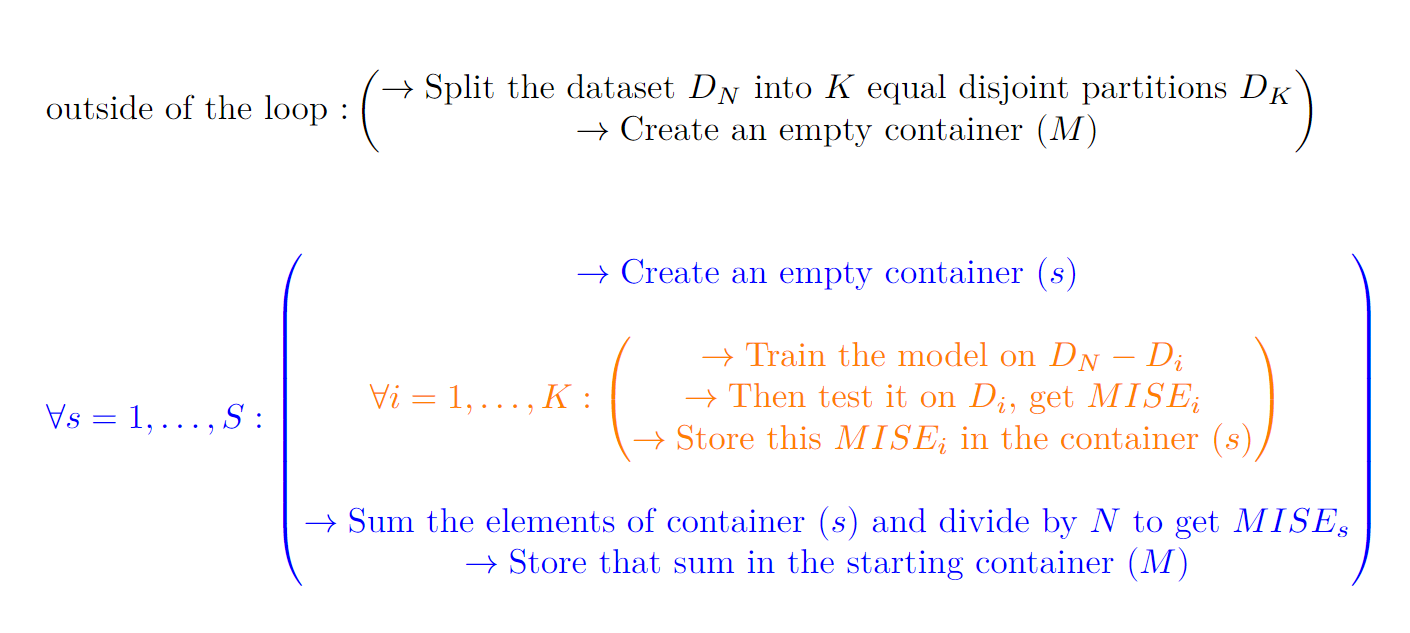




Then we print $(M)$ and find the minimum for example.

Some remarks:

- The “**winner-takes all**” is the case when $K =N$ and is the best
  cross validation , but is computationally expensive , especially for
  large $N$.

- The complexity parameter can be written as $ s = (s_1 , s_2 , ...) $ and then
  the loop above is performed multiple times , over $s_1$ and over $s_2$, ...
  Example: number of trees and depth are $s = (s_1 , s_2)$ complexity parameters in a random forest model. 
  
 
- It is possible to do a **greedy** $K$ -CV loop, where we the $s_{-i}$
  dimensions are fixed and the $s_i$th varies. This assumes that the error
  estimation is a function in the form of
  $S_1(s_1) \times S_2(s_2) \times ...$ (a product of the components of
  the complexity parameters)

# Random Forests <a name="subparagraph3"></a>

## Intro <a name="rf-intro"></a>


We give an introduction similar to the handbook:

Decision trees , on their own are weak learners. The solution is to combine many different decision trees and make them as uncorrelated as possible in order to reduce variance - this combination (sum) is called a random forest. To be more precise , suppose we have $B$ trees with negligable bias and comparable variance, and mutual correlation $\rho$. It can be shown that $ \text{Variance of random forest } \propto 1/B \times \rho  $ (is proportional to)  , i.e. by either increasing the number of trees , of by decreasing the mutual correlation we reduce the total variance.


The random forest algorithm :


- generates a bootstrab sample (with replacement) of the data $B$ times
- fits each decision tree $b = 1 , ... , B$ , with the set of variables for each split is a random subset (size $n'$)
- stores at each split the impovement of the cost function
- gives the final prediciton as an average over $B$ of all the decision trees
- also gives an importance measure for each variable




For random forests the relevant parameters are: 

- **Number of trees** :  $ntree$  ---> the number of trees
- **Tree depth** : controlled by:
    - $maxnodes$  --->depth of each tree
    - $nodesize$ ---> the minimum node size
- **Features** : $mtry$ ---> the number of features to select
- **Subsample size** : $samplesize$ ---> samples to take from data

In general, it seems best to take the number of trees as high as your computer allows, and not to tune both the subsample size and tree depth, i.e. just tuning one of them while keeping the other fixed.

We will use the default sample size (all $N$ samples of the data) and tune maxnodes from 5 to 8 and default (i.e. no limit). 

DOI:10.1051/PROC/201760144 Corpus ID: 73722505
Tuning parameters in random forests

## HP Search with K-CV <a name="rf-hp-kcv"></a>

Now we apply the K-CV loop to find the best hypothesis space element i.e. the hyperparameter $s$. For random forests , in the "general setup" context, the hypothesis space is the *finite* $\Lambda = \bigcup^S_s \Lambda_s$ where the $\Lambda_s$ are now *disjoint* points on the (possibly) *discretized* "grid" $\Lambda$. 

For example let $ntree = (10,20,30) , \ mtry =  (1,2,3)  ,$ (the other hyperparams. are default) ; $\Lambda$ is a $3\times3$ discrete grid , union of the nine "points".

In [97]:
# For convinience we load the cleaned up/feature selected data again (it is called train_pm25)



train_pm25 <- read.csv("train_data_red.csv")






In [98]:
# We will "code the pseudo-code" for K-CV searching 

# We are using a RF model with the tree number , 
#ntree as a hyperparameter. the other parameters are set to default -
#so it can be considered a step in a greedy search
# the goal is to find the n for which the error stabilizes (and to see if the code works)

library(randomForest)

# We partition D_N into equal and disjoint D_K. We select the first N/K elements , 
#then the next N/K etc... Then inside the loop we specify starting and end 
#indices for the validation and training tests as a function of i in 1,...,K   (method1)


# shuffle the naive_pm first (I've read that shuffling first is better...)


set.seed(1)

# set the number of partitions for cross-validation
K <- 5

# shuffle 
shuffled_pm25 <- train_pm25[sample(nrow(train_pm25), replace = FALSE), ]


# lets not use method1


part_size <- ceiling(nrow(shuffled_pm25) / K)

# the below returns (1,1,1,...) - N/K.times , (2,2,2...) - N/K.times, etc..
# (1,1,1,...,2,2,2,2....,K,K,K,K). You will see how this works out
part_indices <- rep(1:K, each = part_size, length.out = nrow(shuffled_pm25))

# Containter for MISEs 

M <- numeric(0)

In [45]:
# start the loops
# default mtry is p/3 for regression 
# looking for the ntree for which 5-CV stabilizes
# even with a powerful pc (32gb RAM) it becomes too slow to test for trees >100 
# we will do a TOY example below (ntree = 2 ,3)

set.seed(1)

#tracking time
start_time <- Sys.time()

for (ntree_value in 2:3) {
  # container for MISEi
 s <- numeric(0)
  
  for (i in 1:K) {  # the piece below returns a logical vector. If i = 1, 
    #it transforms (1,1,1,...,2,2,2,2....,K,K,K,K) into
      #(TRUE,TRUE,TRUE, ..., FALSE,FALSE, FALSE...FALSE, FALSE,FALSE,FALSE)
    validation_indices <- part_indices == i
    
    
    # R can slice rows/colums with logical vectors. ex: data[ (TRUE,TRUE,FALSE, FALSE...) , ] = data[ c(1,2)  ,]
    # we can use this to split the data into training and validation parts
    validation_data <- shuffled_pm25[validation_indices, ]
    # the minus "validation_iniced" means: remove these rows
    train_data <- shuffled_pm25[-validation_indices, ]
    
    # fit a random forest model for ntree
    rf_model <- randomForest(target ~ ., data = train_data, ntree = ntree_value)
    
    # get h
    predicted <- predict(rf_model, validation_data)
    
    # (h-y)^2 , the error 
    MISEi <- (predicted - validation_data$target)^2
    
    # store in the (s) container
    s <- c(s, MISEi)
  }
  
  # sum the elements of s and divide by N 
  MISEs <- sum(s) / nrow(shuffled_pm25)
  
  # store the MISEs value in the (M) container
  M <- c(M, MISEs)
}

end_time <- Sys.time()

# Print the MISEs values 
print(M)


#time taken 
cat("Time taken to train the random forest model:", end_time - start_time, "\n")

[1] 597.2170 444.1864
Time taken to train the random forest model: 59.18754 


## HP Search with OOB <a name="rf-hp-oob"></a>

Instead of continuing the K-CV search (on the maxnodes for a fixed number of trees for example), we will try a different build-in validation method called "out-of-bag" (OOB) error. In short: for each tree, everytime a boostrap sample (with replacement) is drawn there is a chance that some of the samples don't get drawn - they stay "out of the bag". For each tree ,the randomForest() function keeps track of OOB samples and uses them as a validation set. Roughly speaking , after some procedure on these OOBs an error estimate is created.

OOB error requires only one call of randomForest() for a given hyperparameter , while K-CV requires K trainings. This makes is significantly less time consuming. Also as $ ntrees \rightarrow \infty$ the OOB error converges to CV-loo. 

In [46]:


set.seed(1)


library(randomForest)

# another TOY EXAMPLE

# Let us try to find the best ntree parameter using OOB
# It is the same code as for K-CV , but without the inner loop (the inner loop is performed automatically by the
# function )

# track the time to see the speed of OOB


# Initialize an empty vector to store OOB errors
oob <- numeric(0)


   
#### ADJUST ntrees here 
n_min <-3
n_max <- 5
####


# measure the time
start_time <- Sys.time()

# loop
for (i in n_min:n_max ) {
  
  rf_model <- randomForest(target ~ ., data = train_pm25, ntree = i)
  oob <- c(oob, rf_model$mse[length(rf_model$mse)]) 
}


end_time <- Sys.time()

# find the min
min_error <- min(oob)
optimal_ntree <- which(oob == min_error) + n_min-1

# print everything
cat("Minimum OOB error:", min_error, "\n")
cat("Optimal ntree:", optimal_ntree, "\n")
cat("Time taken:", end_time - start_time, "\n")




Minimum OOB error: 1874.005 
Optimal ntree: 5 
Time taken: 28.00485 


In [6]:
# To find the optimal number of trees and features each tree takes , using oob (or K-cv) 
# we would do a double loop on ntree and mtry
# but even for oob , this is too slow

# we do a "greedy" search as follows: fix ntrees= 50
# search maxnodes = 4 , ... , 9  
# 


set.seed(1)

oob <- numeric(0)


   
#### ADJUST the parameters here 
node_min <-4
node_max <- 9
####


# measure the time
start_time <- Sys.time()

# loop
for (i in node_min:node_max) {
  
  rf_model <- randomForest(target ~ ., data = train_pm25, ntree = 50 , maxdepth = i  )
  oob <- c(oob, rf_model$mse[length(rf_model$mse)]) 
}


end_time <- Sys.time()

# find the min
min_error <- min(oob)
optimal_depth <- which(oob == min_error) + node_min -1

# print everything
cat("Minimum OOB error:", min_error, "\n")
cat("Optimal maxdepth for choosen ntree:", optimal_depth, "\n")
cat("Time taken:", end_time - start_time, "\n")

Minimum OOB error: 1162.404 
Optimal maxdepth for choosen ntree: 9 
Time taken: 2.300698 


 We will take **ntree = 50 , maxnodes = 9 , the rest = default** - as was selected by the oob error estimate.

 Now let us find the 20-CV estimate for later use.

In [15]:


set.seed(1)

# set the number of partitions for cross-validation
K <- 20

# shuffle 
shuffled_pm25 <- train_pm25[sample(nrow(train_pm25), replace = FALSE), ]


# lets not use method1


part_size <- ceiling(nrow(shuffled_pm25) / K)

# the below returns (1,1,1,...) - N/K.times , (2,2,2...) - N/K.times, etc..
# (1,1,1,...,2,2,2,2....,K,K,K,K). You will see how this works out
part_indices <- rep(1:K, each = part_size, length.out = nrow(shuffled_pm25))

# Containter for MISEs 

 s <- numeric(0)
  
  for (i in 1:K) {  # the piece below returns a logical vector. If i = 1, 
    #it transforms (1,1,1,...,2,2,2,2....,K,K,K,K) into
      #(TRUE,TRUE,TRUE, ..., FALSE,FALSE, FALSE...FALSE, FALSE,FALSE,FALSE)
    validation_indices <- part_indices == i
    
    
    # R can slice rows/colums with logical vectors. ex: data[ (TRUE,TRUE,FALSE, FALSE...) , ] = data[ c(1,2)  ,]
    # we can use this to split the data into training and validation parts
    validation_data <- shuffled_pm25[validation_indices, ]
    # the minus "validation_iniced" means: remove these rows
    train_data <- shuffled_pm25[-validation_indices, ]
    
    # fit a random forest model for ntree
    rf_model <- randomForest(target ~ ., data = train_data ,ntree = 50 , maxnodes = 9)
    
    # get h
    predicted <- predict(rf_model, validation_data)
    
    # (h-y)^2 , the error 
    MISEi <- (predicted - validation_data$target)^2
    
    # store in the (s) container
    s <- c(s, MISEi)
  }
  
  # sum the elements of s and divide by N 
  MISEs <- sum(s) / nrow(shuffled_pm25)


print(MISEs)


####### this is the 20-CV generalization error estimate , 1579.008  ######


[1] 1579.008


## Variable Importance with RF <a name="rf-importance"></a>


Another use of the OOB samples is to construct an importance measure of the features.  The details of the exact procedure can be found in (Hastie et al., 2009 ). It might be interesting to compare the OOB feature importance to the one we will find in Question 5.

For a practical implementation in R , the randomForest() has a built in parameter that calculates OOB variable importance in different ways. The default is often accurate (nodePurity) , but a better way is to use "permutation importances". See https://explained.ai/rf-importance/index.html for a details.

In [99]:
# Quick example of variable importance following the advice in the above link

# The point is to show that there are 2 variable ranking methods (both built in randomForest() function)
# the 2nd one "is better" , but the 1st default is generally good.


# change the col names for conveniance



simple_train_pm25 <- train_pm25

# for reference
true_columns <- c("target", "relative_humidity_2m_above_ground", "u_component_of_wind_10m_above_ground",
             "L3_O3_O3_column_number_density", "L3_O3_cloud_fraction", "L3_NO2_NO2_slant_column_number_density",
             "L3_NO2_cloud_fraction", "L3_NO2_tropopause_pressure", "L3_CO_CO_column_number_density",
             "L3_CO_cloud_height", "L3_CLOUD_solar_azimuth_angle", "L3_CLOUD_cloud_top_pressure",
             "L3_CLOUD_cloud_optical_depth", "L3_HCHO_tropospheric_HCHO_column_number_density",
             "L3_HCHO_tropospheric_HCHO_column_number_density_amf", "L3_SO2_absorbing_aerosol_index",
             "L3_SO2_SO2_slant_column_number_density")


columns <- c("target", "r_humidity", "u_wind",
             "O3_CND", "O3_CF", "NO2_SCND",
             "NO2_CF", "NO2_TP", "CO_CND",
             "CO_CH", "C_s_angle", "CLOUD_CTP",
             "CLOUD_COD", "HCHO_CND",
             "HCHO_CND_a", "SO2_AOI",
             "SO2_SCND")

colnames(simple_train_pm25) <- columns


#View(simple_train_pm25)

In [100]:
# Create a new database where an additional "random" column is added
# This is to see if the variable selection rating rates it very low


set.seed(1)

train_pm25_random <- simple_train_pm25
train_pm25_random['random'] <- runif(nrow(train_pm25_random))


In [50]:
# fit two forests , ntree = 50. The key is to set "importance = TRUE" this gives both 
#the permutation method and the default (node impurity)


set.seed(1)


# this one is with the usual data
rf <- randomForest(target ~ ., data = simple_train_pm25,  ntree = 50, maxnodes = 9 ,importance = TRUE)

#this one is the usual data + a random column
rf_ran <- randomForest(target ~ ., data = train_pm25_random, ntree = 50, maxnodes = 9 ,importance = TRUE)

In [51]:
# See the rankings using permutation importances (MSE accuracy )(2nd method)

imp2 <- importance(rf_ran, type = 1, scale = F)
imp1 <- importance(rf, type = 1, scale = F)


# Default nodepurity method
purity1 <- importance(rf, type = 2, scale = F)
purity_random <- importance(rf_ran, type = 2, scale = F)





#View(purity1)
#View(purity_random)

#View(imp1)
View(imp2)

#Below are the results , could not quite get the order right in Jupyter notebook...
# the 2nd more accurate method rates wind lower and solar higher.

# In any case it could be useful to compare this variable importance to exo.5

,%IncMSE
r_humidity,1.2654069
u_wind,84.5168170
O3_CND,9.4976639
O3_CF,9.7999550
NO2_SCND,210.1466590
NO2_CF,1.0775597
NO2_TP,10.5520850
CO_CND,216.3221626
CO_CH,1.2175908
C_s_angle,68.7364195


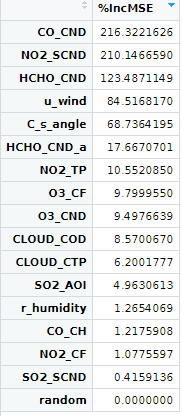

# Lazy Nearest Neighbours (kNN) <a name="subparagraph4"></a>



The k-nearest-neighbours method is a non-parametric supervised learning method that can be used for classification and regression. It consists in finding (for each query) the k-closest values and taking their average distances (in the regression case). Because we are computing distances (by closest we mean with minimal distance) it is very important to use standardized data. The nearest neighobours method is considered lazy since it only depends on one parameter : the number of neighbours it wants to consider.

Also, we can see that for k=1, our k-NN just predicts the same value, thus underfitting the data, for k close to the number of rows, our k-NN just return the average of all the values, overfitting the data. Another big issue with this model is that it's complexity increases exponentially with k and with that our computationnal time.

So we have to find a good trade off in selecting k. For our hyperparameter tunning, we use a random search method and we use cross-validation to estimate the MSE of our predicted models. For this model we will use the lazy package, introduced in 2022 by Mauro Birattari and Gianluca Bontempi (https://cran.r-project.org/web/packages/lazy/lazy.pdf).

In [52]:
library("lazy")
#From our feature selection, we work with the following data (we want to reduce it as much as possible to reduce our computational time):
data_NN <- train_data_red %>% select(colnames(train_data_red)[selected][1:9])
X <- data_NN
Y <- train_data$target

How the model is constructed in lazy :

For each query point, the estimation of the function is obtained by combining different local models. The models considered for combination by lazy are polynomials of degree 0, 1 and 2 that fit a set of samples in the neighborhood of the query point. The local models are identified using the recursive least-squares algorithm, and the leave-one-out cross-validation is obtained through the PRESS statistic. This is from _Lazy Learning for Local Regression_, by _Mauro Birattari_ and _Gianluca Bontempi_ (https://cran.r-project.org/web/packages/lazy/lazy.pdf)

In lazy_control, we set the parameters for our model. Here {con, lin, quad}IPar indicates the number of neighbours used for identifying and validating our {constant, linear, quadratic} model respectively (we can combine them). In distance we can select either Euclidiean or Manhattan distances


predict(data_lazy, train_data_red)$h : returns a vector of size nrow(train_data_red), with in the position i, the estimate of the unknown function for the query point in train_data_red[i,].

It is important to notice that in our case, we have only selected our local models to be linear to reduce computational time once again.

In [69]:
CV_folds <- 5
N <- nrow(data_NN)
R <- ncol(data_NN)

size_CV <-floor(N/CV_folds)
CV_err<-numeric(CV_folds)
K<-c(1,2,3,4,5,6,7,8,9,10)

MSEhat <- numeric(length(K))
for (k in K){
    # Our hyperparameter control is updated for each k in K
    lc <- lazy.control(conIdPar = NULL, linIdPar = k, quaIdPar = NULL, distance = "euclidean")
    # The predictions of each individual model is stored as a column of the Y_hat_ts_ensemble matrix
    Y_hat_ts_ensemble <- matrix(NA,nrow=size_CV, ncol=CV_folds)
    
    for (i in 1:CV_folds){
        idx_ts<-(((i-1)*size_CV+1):(i*size_CV))  ### idx_ts represents the indices of the test set the i-th fold
        X_ts<-X[idx_ts,]  
        Y_ts<-Y[idx_ts]  
     
        idx_tr<-setdiff(1:N,idx_ts) ### idx_tr represents  indices of the training sefor the i-th fold             
        idx_tr_resample <- sample(idx_tr,rep=FALSE)
        X_tr<-X[idx_tr_resample,]
        Y_tr<-Y[idx_tr_resample] 
        DS<-cbind(X_tr,target=Y_tr)
        model <- lazy(target ~ ., DS, control = lc)
        # Storing prediction for the i^th model
        Y_hat_ts_ensemble[,i] <- predict(model,X_ts)$h      
    }
    #Computing ensemble prediction (via model averaging)
    Y_hat_ts <- apply(Y_hat_ts_ensemble,1,mean, na.rm = TRUE)
    MSEhat[k] <-mean((Y_hat_ts-Y_ts)^2)
}
    
best_k <- which.min(MSEhat)
best_lc <- lazy.control(conIdPar = NULL, linIdPar = best_k, quaIdPar = NULL, distance = "euclidean")
DF <- cbind(X,target=Y)
m <- lazy(target ~ ., DF, control = best_lc)

#MSEhat
best_k


#pred <- predict(m,X)$h

[1] 8

In [72]:
MSEhat[best_k]

[1] 2208.833

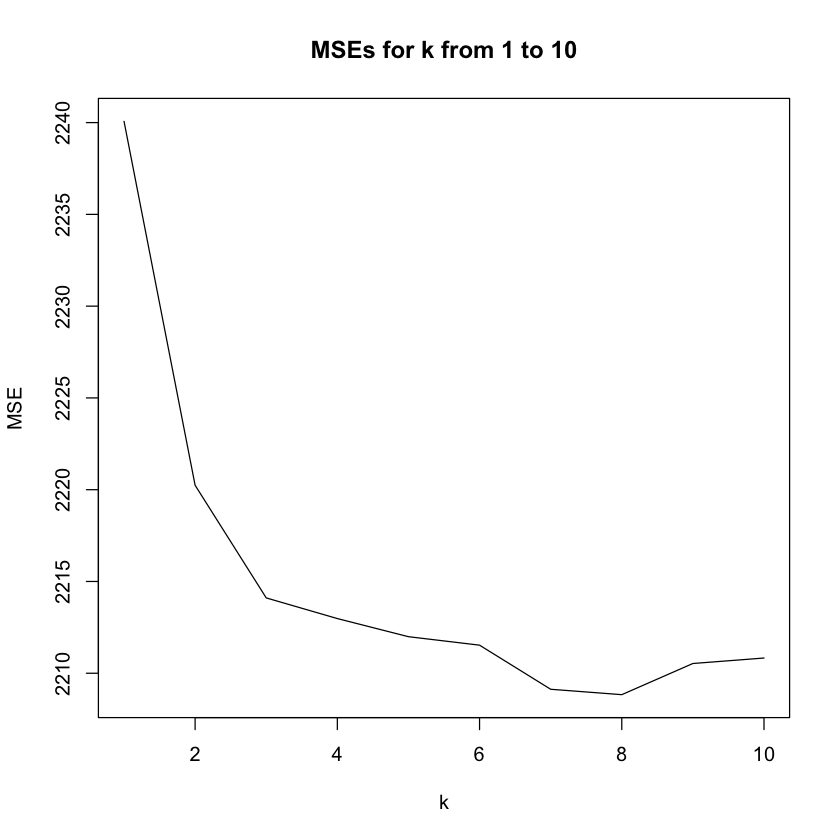

In [73]:
plot(x = seq(1:length(K)), y = MSEhat, type = 'l', main ='MSEs for k from 1 to 10', xlab = "k", ylab = "MSE")

# Lasso <a name="subparagraph5"></a>

Lasso (Least Absolute Shrinkage and Selection Operator) regression is a type of linear regression that includes a regularization term. This regularization term helps to prevent overfitting, which can occur when a model is too complex and fits the training data too closely, capturing noise rather than the underlying pattern.

Lasso regression modifies the cost function of linear regression by adding a penalty term proportional to the absolute value of the coefficients. The objective function for Lasso regression is:

$$\text{Minimize}  \left( \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 + \lambda \sum_{j=1}^{p} | \beta_j | \right)$$

Where:
- $ y_i $ is the actual value.
- $ \hat{y}_i $ is the predicted value.
- $ \beta_j $ are the coefficients.
- $ \lambda $ is the regularization parameter controlling the strength of the penalty.

In [101]:
X_selected <- train_pm25[,c(2,17)]
X_selected <-data.matrix(X_selected)

Y <- train_pm25$target

In [102]:
#write it as a function so we can test it on multiple input data

lasso_regression <- function(x, y, SEED=12345) {
  # Load the necessary package
   if (!require(glmnet)) {
    install.packages("glmnet")
    library(glmnet)
   }
   cv_lasso <- cv.glmnet(x, y, alpha = 1, nfolds = 20)
  
    
    coef_best <- coef(cv_lasso, s = "lambda.min")
    predictions_best <- predict(cv_lasso, s = "lambda.min", newx = x)
    mse_best <- mean((y - predictions_best)^2)
    
   # Optimal lambda that gives minimum mean cross-validated error
   best_lambda <- cv_lasso$lambda.min
   cat("Optimal lambda (lambda.min):", best_lambda, "\n")
   return(list(
    best_lambda = best_lambda,
    coef_best = coef_best,
    mse_best = mse_best,
    predictions_best = predictions_best
  ))
}

In [103]:
dim(X_selected)



results_preselect <- lasso_regression(X_selected, Y)
# print(results_preselect$best_lambda)
# print(results_preselect$coef_best)
cat("MSE preselect:", results_preselect$mse_best, "\n")
# print(head(results_preselect$predictions_best))

[1] 30557     2

Optimal lambda (lambda.min): 0.02171481 
MSE preselect: 2174.061 


## Question 3 <a name="Q3"></a>


### Introduction - gradient boosted trees <a name="q3-intro"></a>


 
We give a short non-technical intro (inspired by the handbook) :

Like with random forest the goal of "boosting" is to combine (a series) weak learners and get a better method.
The training set for an element of this series is dependent on the earlier performance of the previous elements of the series.
  

The boosting method can be extended to trees and the regression case.  In particular there exists a method called gradient boosting trees (more precisely it is a modified version of "forward stage-wise additive" averaging tree algorithms).  


The details can be found in the handbook and in (Hastie et al., 2009 )- we will only do a practical implementation. 

### HP Search with caret() <a name="caret"></a>

Since for this exercise we are allowed other packages , we will use the "caret" library - which simplifies the grid search using built in functions.

So for example, in a K-CV search ,instead of coding multiple hyperparameter loops explicitly , we just specify the grid and and call "TrainCaret(   grid , "our ML method", "cv" )" .   Additionally we can set the search to random , which means the hyperparameters in the grid a chosen randomly instead of an exhaustive search (it is possible to modify the K-CV loop to do a random search also , but that takes too much work... ).

### Recommended HP ranges , greedy strategies ,toy search

In [27]:
library(xgboost)
library(caret)

# as summarized in https://library.oapen.org/bitstream/id/240dc394-c1a4-414e-8465-d9dc8824c7e5/978-981-19-5170-1.pdf,
#these are the recommended ranges and heuristics for the hyper.params

# nrounds :  100 to 10^4 (hundreds to thousands)
# eta (learning rate, shrinkage) :  take <0.1 , ex: 2^−10,2^-9,..., 0.1 
# lambda (regularization) : 2^-10 to 2^10 (powers of)
# alpha (similar to lamda) : -||-
# subsample :  0.5  , or 0.5 to 1
# colsaple_bytree : 0.1 , 0.2 , ... 1
# gamma (controls no. of splits) : 2^-10 , 2^-9 , ... , 2^10
# maxdepth: 4 to 10
# min_child_weight : 2^-10 , 2^-9 , ... , 2^10

### Additionally these are the (known) interactions between:

# nrounds <--> eta <--> subsamples   (A)
# maxdepth <--> min_child_weight     (B)



### Searching for all of these parameters is VERY computationally expensive
# (be it exhaustive, random or bayesian optimisation)


#Let us try two different strategies:


### (1) NAIVE random search with a small hyperparameter grid 
# using the above recommended ranges
# just to test 

### (2) GREEDY ON THE INTERACTIONS (inspired by https://shorturl.at/luLM5)  
# Do an exhaustive search on (A) while fixing the other parameters to default, and
# find the optimal values for (A)
# fix those (A) values and do a random search for (B)


set.seed(1)

# all the parameters below are required , otherwise an error appears in caret

#toy example

hyperparameter_grid <- expand.grid(
  nrounds = c(100, 200, 300),
  max_depth = c(3, 6, 9),
  eta = c(0.01, 0.03, 0.05),
  gamma = c(0, 1, 5),  
  colsample_bytree = c(0.6, 0.8, 1),  
  min_child_weight = c(1, 3, 5),  
  subsample = c(0.6, 0.8, 1)  
)


# caret cannot do random searches on custom grids (only works for the default grid for xgbtrees) ;
#we have to manually sample from the above grid to get a "random grid"

sampled_indices <- sample(nrow(hyperparameter_grid), 5, replace = FALSE)
sampled_hyperparameters <- hyperparameter_grid[sampled_indices, ]


# specify 10-CV as the validation method
my_train_control <- trainControl(method = "cv", number = 10)

#this function (below) does the validation (essentially it does the same as the K-CV loop presented previously).  

fit <- train(
  target ~ .,
  data = train_pm25,
  method = "xgbTree", # we select our method, gradient boosted trees
  trControl = my_train_control, # the 10-CV specified above
  tuneGrid = sampled_hyperparameters, # the grid
  verbose = FALSE
)

print(fit)  # it works...

eXtreme Gradient Boosting 

30557 samples
   16 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 27501, 27502, 27501, 27502, 27501, 27502, ... 
Resampling results across tuning parameters:

  eta   max_depth  gamma  colsample_bytree  min_child_weight  subsample
  0.01  6          1      1.0               5                 0.6      
  0.03  3          1      1.0               1                 0.8      
  0.03  9          1      0.6               3                 0.8      
  0.03  9          5      1.0               5                 1.0      
  0.05  3          5      0.6               1                 1.0      
  nrounds  RMSE      Rsquared   MAE     
  100      44.55152  0.4035865  29.51560
  300      35.91260  0.4157697  25.58423
  300      32.82538  0.5124715  22.81686
  200      33.31699  0.4957724  23.09162
  300      35.43627  0.4304082  25.19189

RMSE was used to select the optimal model using the smallest value.
The final values us

### "Real" search , MSE of final HP 

In [29]:
set.seed(1)

# Now we do the greedy strategy with the recommended ranges

# if we had a powerful computer we would search this grid (notice alpha and lambda added)
#real_grid <- expand.grid(
 # nrounds = seq(100, 10000, by = 100),
  #max_depth = seq(4, 10),
  #eta = c(2^seq(-10, -4), 0.1), 
  #gamma = 2^seq(-10, 10),
  #colsample_bytree = seq(0.1, 1, by = 0.1),
  #min_child_weight = 2^seq(-10, 10),
  #subsample = seq(0.5, 1, by = 0.1),
  #alpha =2^seq(-10, 10),
  #lambda= 2^seq(-10, 10)
#)



# anyways , we stick with the greedy strategy. Everything is fixed except for n,eta since these three intract strongly (subsamples we will keep fixed) .

greedy_grid_A <- expand.grid(
  nrounds = seq(100, 500, by = 100),
  max_depth = 6, 
  eta = c(2^seq(-10, -4), 0.1),
  gamma = 2^0, 
  colsample_bytree = 1, 
  min_child_weight = 1, 
  subsample = 0.5 
)




# specify 10-CV as the validation method
my_train_control <- trainControl(method = "cv", number = 5)

 
#do an exhaustive search for this small grid A
fit <- train(
  target ~ .,
  data = train_pm25,
  method = "xgbTree", # we select our method, gradient boosted trees
  trControl = my_train_control, # the 10-CV specified above
  tuneGrid = greedy_grid_A, # the grid
  verbose = FALSE,
     verbosity = 0
)


print(fit)



eXtreme Gradient Boosting 

30557 samples
   16 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 24445, 24445, 24446, 24447, 24445 
Resampling results across tuning parameters:

  eta           nrounds  RMSE      Rsquared   MAE     
  0.0009765625  100      71.37801  0.3688822  55.06046
  0.0009765625  200      66.71790  0.3729178  50.04362
  0.0009765625  300      62.60344  0.3766014  45.65223
  0.0009765625  400      58.98112  0.3803827  41.92084
  0.0009765625  500      55.80203  0.3842365  38.81499
  0.0019531250  100      66.71282  0.3726751  50.03805
  0.0019531250  200      58.97178  0.3805683  41.91194
  0.0019531250  300      53.00954  0.3880585  36.25055
  0.0019531250  400      48.46343  0.3952793  32.41277
  0.0019531250  500      45.03040  0.4024798  29.82858
  0.0039062500  100      58.95862  0.3793426  41.89609
  0.0039062500  200      48.44325  0.3944217  32.39409
  0.0039062500  300      42.45279  0.4083306  28.08445
  0.00390

In [3]:
set.seed(1)

library(xgboost)
library(caret)

#this is the result, now let us do a search on (B)

#RMSE 33.18993  
#nrounds = 500, 
#max_depth = 6, 
#eta= 0.0625, 
#gamma = 1, 
#colsample_bytree = 1,
#min_child_weight = 1 
#subsample = 0.5.

greedy_grid_B <- expand.grid(
  nrounds = 500,
  max_depth = c(4,5,6,7,8), 
  eta =  0.0625,
  gamma = 1, 
  colsample_bytree = 1, 
  min_child_weight = 2^seq(-3, 3), 
  subsample = 0.5 
)



sampled_indices <- sample(nrow(greedy_grid_B), 10, replace = FALSE)
sampled_hyperparameters <- greedy_grid_B[sampled_indices, ]



my_train_control <- trainControl(method = "cv", number = 5)

 

fit <- train(
  target ~ .,
  data = train_pm25,
  method = "xgbTree", # we select our method, gradient boosted trees
  trControl = my_train_control, # the 5-CV specified above
  tuneGrid = sampled_hyperparameters, # the grid
  verbose = FALSE,
     verbosity = 0
)


print(fit)

Loading required package: ggplot2

Loading required package: lattice



eXtreme Gradient Boosting 

30557 samples
   16 predictor

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 24445, 24445, 24446, 24447, 24445 
Resampling results across tuning parameters:

  max_depth  min_child_weight  RMSE      Rsquared   MAE     
  4          0.125             33.99321  0.4740312  23.83642
  4          0.250             34.06090  0.4718684  23.88521
  4          0.500             34.08308  0.4711816  23.86763
  4          1.000             34.03467  0.4727215  23.84108
  4          2.000             34.14773  0.4692318  23.91790
  4          4.000             34.23617  0.4665077  23.98315
  4          8.000             34.16369  0.4688733  23.95088
  5          0.125             33.61511  0.4855535  23.40747
  5          0.250             33.58193  0.4865192  23.40181
  5          0.500             33.54813  0.4875911  23.40830
  5          1.000             33.57493  0.4867590  23.41904
  5          2.000             33.61048  0.4856

In [ ]:
# The final values used for the model were (RMSE 32.92176)
#nrounds = 500, 
#max_depth = 8, 
#eta= 0.0625, 
#gamma = 1, 
#colsample_bytree = 1, 
#min_child_weight = 0.25
# subsample = 0.5.


# so a very slight improvement... but we take it

In [14]:
set.seed(1)


library(xgboost)
library(caret)


#let us verify the "true RMSE" by doing 20-CV 


# Define the parameter grid
param_grid <- expand.grid(
  max_depth = 8,
  eta = 0.0625,
  gamma = 1,
  colsample_bytree = 1,
  min_child_weight = 0.25,
  subsample = 0.5,
  nrounds = 500
)




my_train_control <- trainControl(method = "cv", number = 20)

 

fit <- train(
  target ~ .,
  data = train_pm25,
  method = "xgbTree", # we select our method, gradient boosted trees
  trControl = my_train_control, # the 20-CV specified above
  tuneGrid = param_grid, # the grid
  verbose = FALSE,
     verbosity = 0
)


print(fit)


### MSE 1054


Loading required package: ggplot2


Attaching package: 'ggplot2'


The following object is masked from 'package:randomForest':

    margin


Loading required package: lattice



eXtreme Gradient Boosting 

30557 samples
   16 predictor

No pre-processing
Resampling: Cross-Validated (20 fold) 
Summary of sample sizes: 29029, 29030, 29029, 29029, 29029, 29030, ... 
Resampling results:

  RMSE      Rsquared   MAE     
  32.46793  0.5200384  22.49381

Tuning parameter 'nrounds' was held constant at a value of 500
Tuning
 held constant at a value of 0.25
Tuning parameter 'subsample' was
 held constant at a value of 0.5


In [23]:
View(fit$results$RMSE^2)

[1] 1054.166

## Comparison of all the models <a name="Q4"></a>


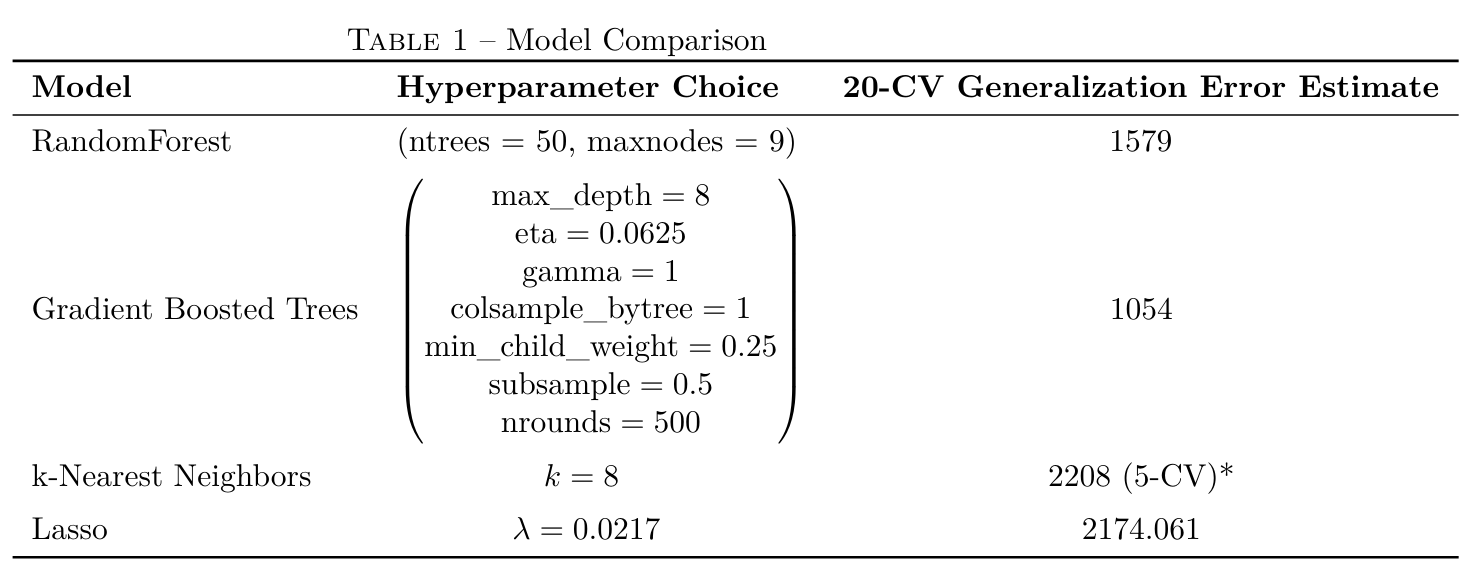




## We choose the one with the lowest MSE - **the gradient boosted trees using the xgb library**

# Question 4 <a name="Q4"></a>

In [104]:


test <- read.csv("Test.csv", header = T, na.strings = "NA")

# only take the columns we used in test
true_columns <- c("relative_humidity_2m_above_ground", "u_component_of_wind_10m_above_ground",
                  "L3_O3_O3_column_number_density", "L3_O3_cloud_fraction", "L3_NO2_NO2_slant_column_number_density",
                  "L3_NO2_cloud_fraction", "L3_NO2_tropopause_pressure", "L3_CO_CO_column_number_density",
                  "L3_CO_cloud_height", "L3_CLOUD_solar_azimuth_angle", "L3_CLOUD_cloud_top_pressure",
                  "L3_CLOUD_cloud_optical_depth", "L3_HCHO_tropospheric_HCHO_column_number_density",
                  "L3_HCHO_tropospheric_HCHO_column_number_density_amf", "L3_SO2_absorbing_aerosol_index",
                  "L3_SO2_SO2_slant_column_number_density")


test_subset <- test[, true_columns]













In [9]:

set.seed(1)


library(xgboost)

# our params
params <- list(
  max_depth = 8,
  eta = 0.0625,
  gamma = 1,
  colsample_bytree = 1,
  min_child_weight = 0.25,
  subsample = 0.5
)

# call the xgboost() function ( notice this time there is no caret() involved )
model <- xgboost(data = as.matrix(train_pm25[, -1]),  
                 label = train_pm25$target, 
                 nrounds = 500,
                 params = params,
                 verbose = 0)



In [ ]:
#predictions for the test
predictions <- predict(model, newdata = as.matrix(test_subset))

print(predictions)

In [12]:
#write.csv(predictions, "C:/Users/User/Desktop/predictions.csv", row.names = FALSE)


# Question 5 <a name="Q5"></a>


### Introduction <a name="q5-intro"></a>



Denote $\boldsymbol{X}^{-i} = \text{"set of all features with the i-th feature removed "}$.

We take the conditional information of the i-th feature( $\boldsymbol{x}_i$ ) about the target $\boldsymbol{y}$ given $\boldsymbol{X}^{-i}$ as a measure of importance of $\boldsymbol{x}_i$ .

This conditional information can be expressed as:

$$
I(\boldsymbol{x}_i ; \boldsymbol{y} | \boldsymbol{X}^{-i} ) =  H(\boldsymbol{y} | \boldsymbol{X}^{-i}) -  H(\boldsymbol{y} | \boldsymbol{X})
$$

with $H( z |w ) = \text{ conditional entropy of z given w  } = \text{" uncertainty in z given w  "}$

These conditional entropies can be approximated by the generalization error (p275. handbook) , in our case it ( $\hat{G}_N$) would be found leave-one-out cross vaildation with a quadratic loss function .

### Pseudo Code <a name="q5-code"></a>

In [ ]:
### According to the handbook ,the conditional entropy can be approximated by cv-loo

 
## training on the full features, say we have found the best model (M) with the best hyperparameters (H0)
# the CV g-error corresponds to 2nd term on the RHS ,  i.e. H(y|X)  


## for the 1st term of the RHS , H(y|X^-i): for each feature , we need to drop that feature (column) from the data,  
# retrain the model (i.e. best hyper.params search) , and find the corresponding CV g-error. 
#Since we have 16 features, the retraining needs to be done 16 times.




### Here is the pseudo code for the variable importance:

# lowest_MSE <- "empty container"

# for each f in no.features: {

        # data = data[, -f]
        # fit <-  "train on data[, -f] " 
        # lowest_MSE <- cbind( lowest_MSE, min(fit$MSE) ) }

# variable_importance_score <-  lowest_MSE - H(y|X) 

# Then we can bind variable_importance_score with the corresponding colums and "sort" to a nice overview.



## Application to gradient boosted trees <a name="appli"></a>

For simplicity we will use caret(). Doing so effectively replaces need for a "manual K-CV loop" in the code.

Since we are retraining 16 times , to make it feasible on our hardware (i.e. reduce computational time), we will:

- only do CV $K=5$ 
- fix all the hyperparameters to default, $nround = 300$ , $ eta = (2^{-5} , 2^{-4} , 0.1)  $
(we are only doing a limited scan for the learning rate for fixed nrounds, the reasoning is that these two are the most important and have the strongest interaction )

In [4]:
# following the pseudo code

set.seed(1)

library(xgboost)
library(caret)

# take this greedy grid
hyperparameter_grid <- expand.grid(
  nrounds = 300,
  max_depth = 6,
  eta = c(2^seq(-5, -4), 0.1),
  gamma = 0,  
  colsample_bytree = 1,  
  min_child_weight = 1,  
  subsample = 1  
)

lowest_MSE <- numeric(0)

# loop over -features
for (f in 2:17) {
  my_train_control <- trainControl(method = "cv", number = 5)

 
  fit <- train(
    target ~ .,
    data = train_pm25[, -f],  
    method = "xgbTree", 
    trControl = my_train_control, # 5 CV
      tuneGrid = hyperparameter_grid, 
    verbose = FALSE
  )

  
  lowest_MSE <- cbind(lowest_MSE, min(fit$results$RMSE^2))
}


lowest_MSE <- lowest_MSE - 1054 


View(lowest_MSE)


#it took about 1h on a 4gb RAM laptop to do this calculation






85.07469,105.8722,86.71582,69.15929,118.8825,61.49327,110.5796,134.2043,52.14542,91.17078,70.66751,74.6589,75.60967,96.62163,73.55708,56.67309


In [5]:


### combining the variable_importance with the associated features and sort

numerical_values <- c(85.07469, 105.8722, 86.71582, 69.15929, 118.8825, 61.49327, 110.5796, 134.2043, 52.14542, 91.17078, 70.66751, 74.6589, 75.60967, 96.62163, 73.55708, 56.67309)
feature_names <- c("r_humidity", "u_wind", "O3_CND", "O3_CF", "NO2_SCND", "NO2_CF", "NO2_TP", "CO_CND", "CO_CH", "C_s_angle", "CLOUD_CTP", "CLOUD_COD", "HCHO_CND", "HCHO_CND_a", "SO2_AOI", "SO2_SCND")

combined_df <- data.frame(
  Feature = feature_names,
  Value = numerical_values
)


sorted_df <- combined_df[order(-combined_df$Value), ]

print(sorted_df)

      Feature     Value
8      CO_CND 134.20430
5    NO2_SCND 118.88250
7      NO2_TP 110.57960
2      u_wind 105.87220
14 HCHO_CND_a  96.62163
10  C_s_angle  91.17078
3      O3_CND  86.71582
1  r_humidity  85.07469
13   HCHO_CND  75.60967
12  CLOUD_COD  74.65890
15    SO2_AOI  73.55708
11  CLOUD_CTP  70.66751
4       O3_CF  69.15929
6      NO2_CF  61.49327
16   SO2_SCND  56.67309
9       CO_CH  52.14542


In [ ]:
# For reference here are the exact names of the columns

#true_columns <- c("target", "relative_humidity_2m_above_ground", "u_component_of_wind_10m_above_ground",
             #"L3_O3_O3_column_number_density", "L3_O3_cloud_fraction", "L3_NO2_NO2_slant_column_number_density",
             #"L3_NO2_cloud_fraction", "L3_NO2_tropopause_pressure", "L3_CO_CO_column_number_density",
             #"L3_CO_cloud_height", "L3_CLOUD_solar_azimuth_angle", "L3_CLOUD_cloud_top_pressure",
             #"L3_CLOUD_cloud_optical_depth", "L3_HCHO_tropospheric_HCHO_column_number_density",
             #"L3_HCHO_tropospheric_HCHO_column_number_density_amf", "L3_SO2_absorbing_aerosol_index",
             #"L3_SO2_SO2_slant_column_number_density")


#columns <- c("target", "r_humidity", "u_wind",
            # "O3_CND", "O3_CF", "NO2_SCND",
             #"NO2_CF", "NO2_TP", "CO_CND",
             #"CO_CH", "C_s_angle", "CLOUD_CTP",
             #"CLOUD_COD", "HCHO_CND",
             #"HCHO_CND_a", "SO2_AOI",
             #"SO2_SCND")

## Discussion

| Feature     | Importance    |
|-------------|-----------|
| CO_CND      | 134.20430 |
| NO2_SCND    | 118.88250 |
| NO2_TP      | 110.57960 |
| u_wind      | 105.87220 |
| HCHO_CND_a  | 96.62163  |
| C_s_angle   | 91.17078  |
| O3_CND      | 86.71582  |
| r_humidity  | 85.07469  |
| HCHO_CND    | 75.60967  |
| CLOUD_COD   | 74.65890  |



Above are the top 10 most important variables according to the procedure descibed in exercise 5.


- In the "top10" we see the column densities of polluting gases (CO , NO2  ,HCHO , O3) - intuitively these should explain the pm25 target the most. (cloud optical density is also present)

- Also we see the meterological features : u_wind , r_humidity as important - also intuitive.

- the solar azimuth angle is also included.



It is interesting to compare this variable importance to the built-in importance in the RandomForest() function:

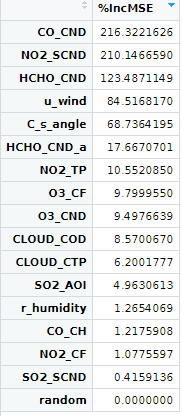

We see that they roughly agree on the top10.

Some remarks:
- both include all the column densities of dangerous gases (albeit HCHO is low rated for exe5)
- humidity is not in the top10 for random forests
- the sensor azimuthal angle is important for both


Of course , we need to take into account our limited "scanning range" (3 values of eta) and low $K$ in the cross validation.  Allowing the hyperparameter grid to take on more values (like we did in the training for the full feature data) should give a more accurate importance ranking.  